In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool
from torch.nn import Linear, ReLU, Dropout
from torch_geometric.loader import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from skimage.segmentation import slic, mark_boundaries
from skimage.color import rgb2lab
from skimage.measure import regionprops
from skimage.color import rgb2gray
from collections import Counter

# Thiết lập và cấu hình
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Định nghĩa các lớp
code = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}
new_size = 100  # Kích thước ảnh sau resize

In [2]:
# Hàm tiện ích
def get_name(code_number):
    return list(code.keys())[list(code.values()).index(code_number)]

In [3]:
def load_images(path, folder_name):
    X, y = [], []
    if folder_name != 'seg_pred':
        for folder in os.listdir(os.path.join(path, folder_name)):
            files = gb.glob(os.path.join(path, folder_name, folder, '*.jpg'))
            for file in files:
                image = cv2.imread(file)
                image = cv2.resize(image, (new_size, new_size))
                X.append(image)
                y.append(code[folder])
    else:
        files = gb.glob(os.path.join(path, folder_name, '*.jpg'))
        for file in files:
            image = cv2.imread(file)
            image = cv2.resize(image, (new_size, new_size))
            X.append(image)
    return np.array(X), np.array(y)

# Tải dữ liệu
train_path = './data/intel-image-classification/seg_train/'
test_path = './data/intel-image-classification/seg_test/'

X_train, y_train = load_images(train_path, 'seg_train')
X_test, y_test = load_images(test_path, 'seg_test')

print(f"Training data: {len(X_train)} images")
print(f"Test data: {len(X_test)} images")

Training data: 14034 images
Test data: 3000 images


In [12]:
import os
import torch
from torch_geometric.data import Data
from tqdm import tqdm
import numpy as np
from skimage.segmentation import slic
from skimage.color import rgb2lab, rgb2gray
from skimage.measure import regionprops
import networkx as nx

def compute_rag(image, segments):
    graph = nx.Graph()
    lab_image = rgb2lab(image)
    for i in range(segments.shape[0]):
        for j in range(segments.shape[1]):
            current = segments[i, j]
            for di, dj in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < segments.shape[0] and 0 <= nj < segments.shape[1]:
                    neighbor = segments[ni, nj]
                    if neighbor != current:
                        graph.add_edge(current, neighbor)
    for node in graph.nodes():
        mask = (segments == node)
        mean_color = np.mean(lab_image[mask], axis=0)
        graph.nodes[node]['feature'] = mean_color
    return graph

def extract_superpixel_features(image, segments):
    grayscale_image = rgb2gray(image)
    features = []
    props = regionprops(segments, intensity_image=grayscale_image)
    for region in props:
        mask = (segments == region.label)
        mean_color = np.mean(image[mask], axis=0)
        eccentricity = region.eccentricity
        bbox = region.bbox
        aspect_ratio = (bbox[3] - bbox[1]) / (bbox[2] - bbox[0]) if (bbox[2] - bbox[0]) > 0 else 0
        solidity = region.solidity
        centroid = region.centroid
        perimeter = region.perimeter
        features.append([*mean_color, eccentricity, aspect_ratio, solidity, *centroid, perimeter])
    return np.array(features)

def image_to_graph(image, n_segments=400):
    segments = slic(image, n_segments=n_segments, compactness=10)
    graph = compute_rag(image, segments)
    features = extract_superpixel_features(image, segments)
    node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(graph.nodes())}
    mapped_edges = [(node_mapping[u], node_mapping[v]) for u, v in graph.edges if u in node_mapping and v in node_mapping]
    edge_index = torch.tensor(mapped_edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(features, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

def save_graphs(images, labels, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for idx, (img, label) in enumerate(tqdm(zip(images, labels), total=len(images), desc=f"Processing {output_dir}")):
        try:
            data = image_to_graph(img)
            data.y = torch.tensor([label], dtype=torch.long)
            torch.save(data, os.path.join(output_dir, f"graph_{idx}.pt"))
        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {idx}: {e}")

# === Gọi xử lý ===
save_graphs(X_train, y_train, 'graphs/train_graphs')
save_graphs(X_test, y_test, 'graphs/test_graphs')


Processing graphs/test_graphs: 100%|██████████| 3000/3000 [29:43<00:00,  1.68it/s]


In [15]:
def load_graphs_from_folder(folder):
    graphs = []
    files = sorted([f for f in os.listdir(folder) if f.endswith('.pt')])
    
    for file in tqdm(files, desc=f"Loading graphs from {folder}"):
        path = os.path.join(folder, file)
        try:
            data = torch.load(path, weights_only=False)
            graphs.append(data)
        except Exception as e:
            print(f"Lỗi khi load {file}: {e}")
    
    return graphs

train_graphs = load_graphs_from_folder('graphs/train_graphs')
test_graphs = load_graphs_from_folder('graphs/test_graphs')


Loading graphs from graphs/test_graphs: 100%|██████████| 3000/3000 [00:43<00:00, 69.36it/s]


In [16]:
class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dims[0])
        self.bn1 = BatchNorm(hidden_dims[0])
        self.conv2 = GCNConv(hidden_dims[0], hidden_dims[1])
        self.bn2 = BatchNorm(hidden_dims[1])
        self.conv3 = GCNConv(hidden_dims[1], hidden_dims[2])
        self.bn3 = BatchNorm(hidden_dims[2])
        self.fc1 = Linear(hidden_dims[2], hidden_dims[3])
        self.fc2 = Linear(hidden_dims[3], num_classes)
        self.relu = ReLU()
        self.dropout = Dropout(dropout)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.relu(self.bn3(self.conv3(x, edge_index)))
        x = global_mean_pool(x, batch)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [21]:
import copy

# DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# Khởi tạo mô hình
model = GCNModel(input_dim=9, hidden_dims=[128, 64, 32, 16], num_classes=6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Tạo thư mục lưu mô hình
os.makedirs("model", exist_ok=True)

# Biến theo dõi
best_accuracy = 0.0
patience = 10
epochs_no_improve = 0
max_epochs = 100

for epoch in range(max_epochs):
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Đánh giá
    model.eval()
    correct = 0
    y_pred, y_true = [], []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y.view(-1)).sum().item()
            y_pred.extend(pred.cpu().numpy())
            y_true.extend(data.y.view(-1).cpu().numpy())

    accuracy = correct / len(test_graphs)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_no_improve = 0
        # Lưu cả model và optimizer
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss,
            'accuracy': accuracy
        }, "model/gcn_slic.pth")
        print(f"✅ Cải thiện - mô hình đã được lưu vào model/gcn_slic.pth (Accuracy: {accuracy:.4f})")
    else:
        epochs_no_improve += 1
        print(f"⚠️ Không cải thiện ({epochs_no_improve}/{patience})")
        break

Epoch 1, Loss: 591.9675, Accuracy: 0.5893
✅ Cải thiện - mô hình đã được lưu vào model/gcn_slic.pth (Accuracy: 0.5893)
Epoch 2, Loss: 490.2173, Accuracy: 0.6260
✅ Cải thiện - mô hình đã được lưu vào model/gcn_slic.pth (Accuracy: 0.6260)
Epoch 3, Loss: 458.5858, Accuracy: 0.5077
⚠️ Không cải thiện (1/10)
Epoch 4, Loss: 436.9369, Accuracy: 0.6500
✅ Cải thiện - mô hình đã được lưu vào model/gcn_slic.pth (Accuracy: 0.6500)
Epoch 5, Loss: 421.6151, Accuracy: 0.5567
⚠️ Không cải thiện (1/10)
Epoch 6, Loss: 411.4620, Accuracy: 0.6070
⚠️ Không cải thiện (2/10)
Epoch 7, Loss: 401.3578, Accuracy: 0.6947
✅ Cải thiện - mô hình đã được lưu vào model/gcn_slic.pth (Accuracy: 0.6947)
Epoch 8, Loss: 393.7698, Accuracy: 0.6993
✅ Cải thiện - mô hình đã được lưu vào model/gcn_slic.pth (Accuracy: 0.6993)
Epoch 9, Loss: 385.7543, Accuracy: 0.6887
⚠️ Không cải thiện (1/10)
Epoch 10, Loss: 381.2827, Accuracy: 0.7227
✅ Cải thiện - mô hình đã được lưu vào model/gcn_slic.pth (Accuracy: 0.7227)
Epoch 11, Loss: 380

KeyboardInterrupt: 


Classification Report:
              precision    recall  f1-score   support

   buildings       0.58      0.80      0.67       437
      forest       0.97      0.77      0.86       474
     glacier       0.80      0.70      0.75       553
    mountain       0.77      0.65      0.70       525
         sea       0.70      0.81      0.75       510
      street       0.74      0.75      0.75       501

    accuracy                           0.74      3000
   macro avg       0.76      0.75      0.75      3000
weighted avg       0.76      0.74      0.75      3000



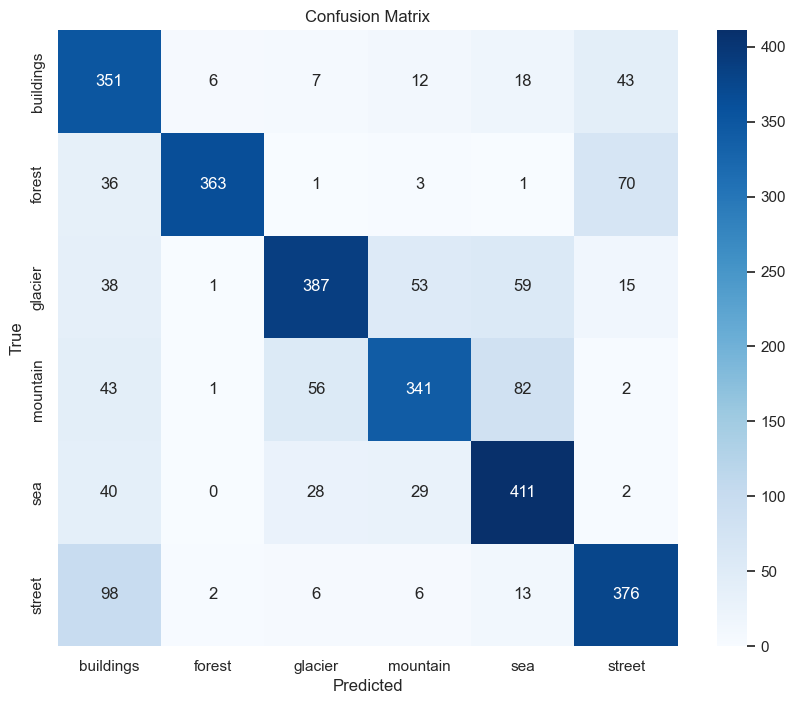

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# Dùng danh sách nhãn từ 0 đến 5
labels = list(code.values())
target_names = list(code.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=labels, target_names=target_names))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


---

# 🔍 **Đánh giá Confusion Matrix**

---

## ✅ **Lớp được mô hình phân loại tốt**

| **Lớp**     | **Số mẫu phân loại đúng** | **Nhận xét**                                                             |
| ----------- | ------------------------- | ------------------------------------------------------------------------ |
| **forest**  | 363                       | Mô hình phân biệt tốt, chỉ nhầm nhẹ với `buildings` và `street`.         |
| **glacier** | 387                       | Phân loại khá tốt, nhưng vẫn có một số nhầm lẫn với `mountain` và `sea`. |
| **sea**     | 411                       | Nhận diện rất tốt, tỷ lệ chính xác cao, ít nhầm với các lớp khác.        |

---

## ⚠️ **Lớp có độ chính xác thấp**

| **Lớp**       | **Số mẫu phân loại đúng** | **Nhận xét**                                                                                   |
| ------------- | ------------------------- | ---------------------------------------------------------------------------------------------- |
| **buildings** | 351                       | Dù đúng nhiều, vẫn nhầm khá nhiều với `street` (43) và một phần với `sea` và `mountain`.       |
| **mountain**  | 341                       | Nhầm lẫn đáng kể với `glacier` (56) và `sea` (82), gây ảnh hưởng tới độ chính xác.             |
| **street**    | 376                       | Nhìn chung tốt, nhưng vẫn nhầm nhiều với `buildings` (98), cho thấy khó phân biệt cảnh đô thị. |

---

## 🔄 **Các cặp lớp thường bị nhầm lẫn**

| **Cặp lớp bị nhầm**    | **Số lượng nhầm lẫn** | **Nhận xét**                                                       |
| ---------------------- | --------------------- | ------------------------------------------------------------------ |
| `street` → `buildings` | 98                    | Nhầm nhiều, có thể do hình ảnh phố xá chứa nhiều tòa nhà.          |
| `mountain` → `sea`     | 82                    | Có thể do vùng biển giáp núi gây nhiễu trong mô hình.              |
| `glacier` → `mountain` | 53                    | Đặc điểm vùng băng trên núi dễ gây nhầm lẫn giữa hai lớp này.      |
| `glacier` → `sea`      | 59                    | Có thể là do đặc điểm màu sắc sáng/trắng/lam tương đồng trong ảnh. |
| `buildings` → `street` | 43                    | Mô hình có xu hướng trộn lẫn khung cảnh đường phố và kiến trúc.    |

---

## 🧾 **Kết luận**

* Mô hình có **hiệu suất tốt với các lớp** như `forest`, `sea`, và `glacier`.
* Tuy nhiên, còn **nhầm lẫn giữa các lớp có đặc điểm thị giác tương tự**, đặc biệt là các vùng cảnh quan đô thị và thiên nhiên lẫn lộn như:

  * `buildings` ↔ `street`
  * `mountain` ↔ `sea`
  * `glacier` ↔ `mountain` và `sea`
* Gợi ý cải thiện:

  * Sử dụng thêm đặc trưng texture hoặc màu sắc tăng cường (augmentation theo ánh sáng/mùa).
  * Áp dụng kiến trúc có attention hoặc positional encoding để tăng phân biệt.

---

In [23]:
def predict_sample(image):
    graph = image_to_graph(image)
    graph.batch = torch.zeros(graph.num_nodes, dtype=torch.long)
    graph = graph.to(device)
    
    model.eval()
    with torch.no_grad():
        out = model(graph)
        pred = out.argmax().item()
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted: {get_name(pred)}')
    plt.axis('off')
    plt.show()

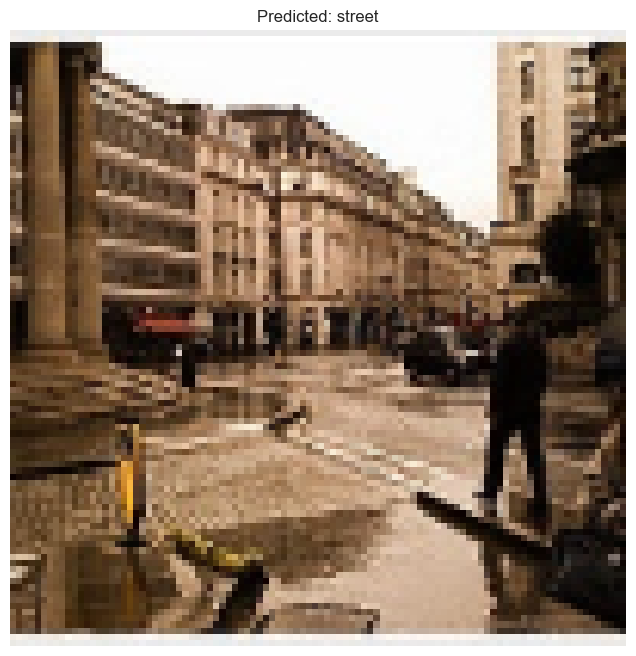

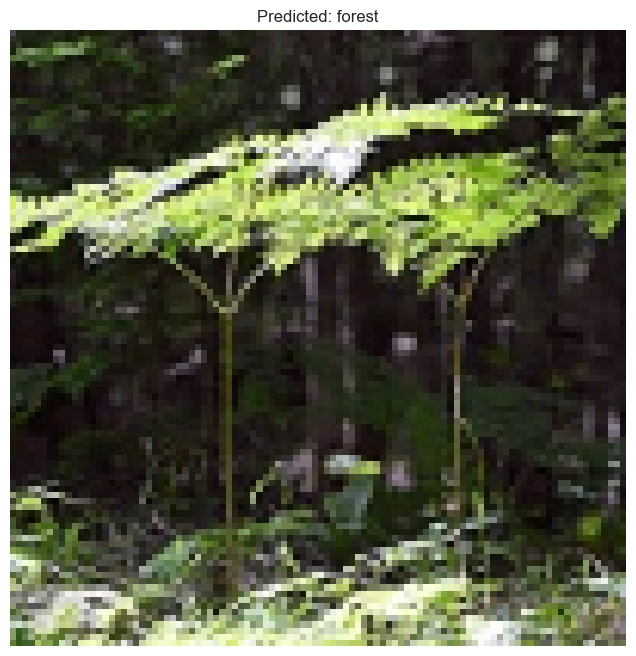

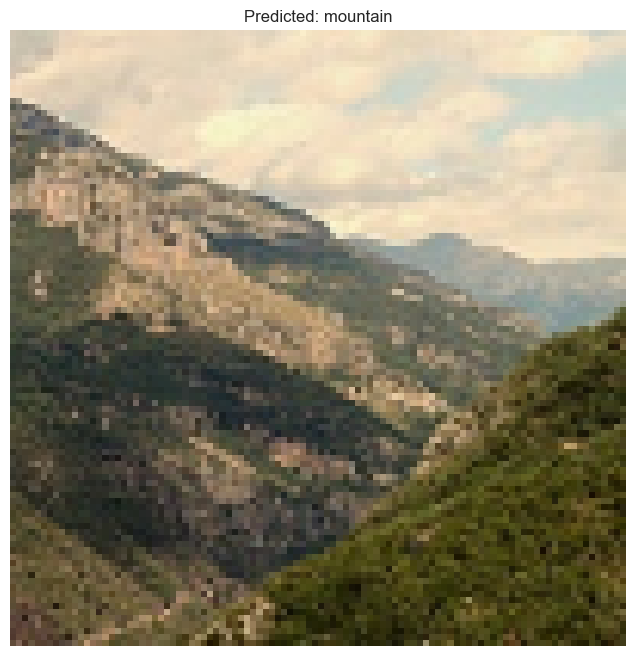

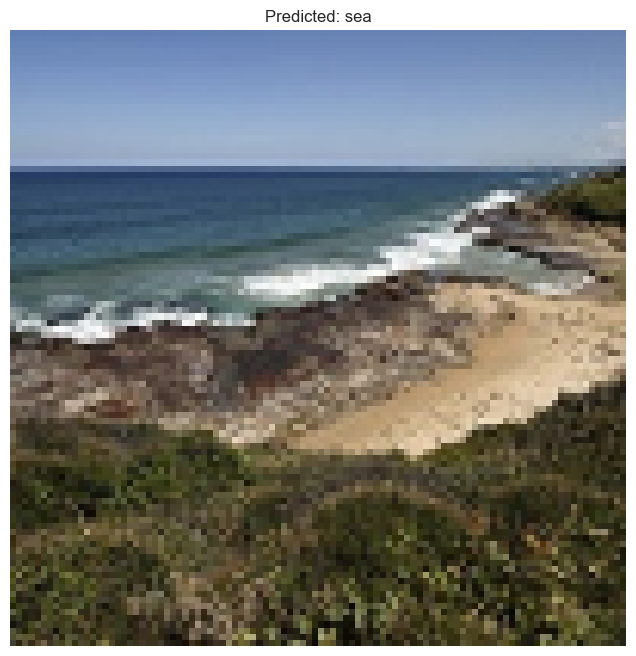

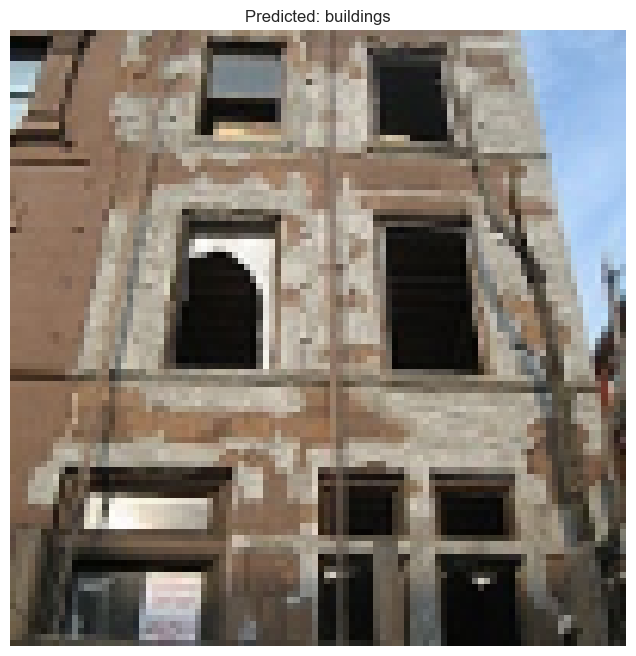

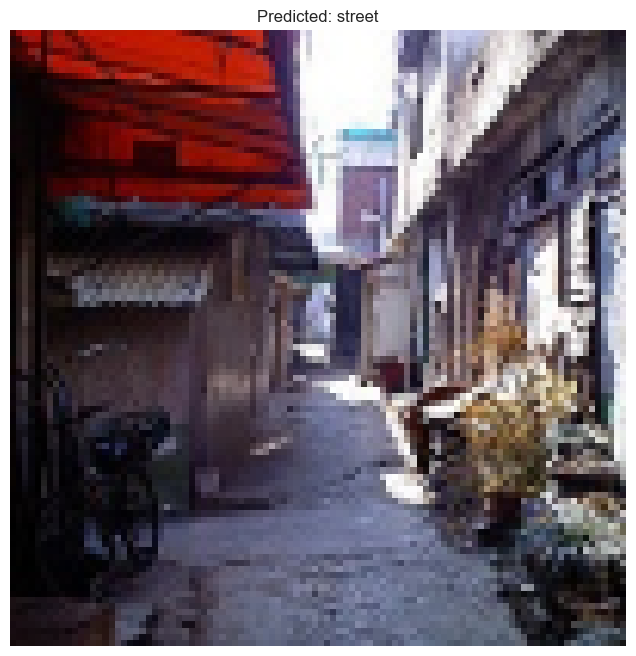

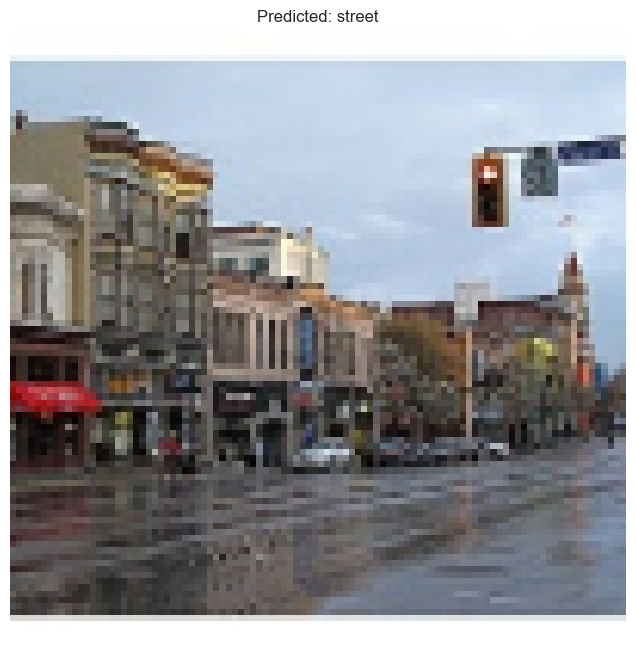

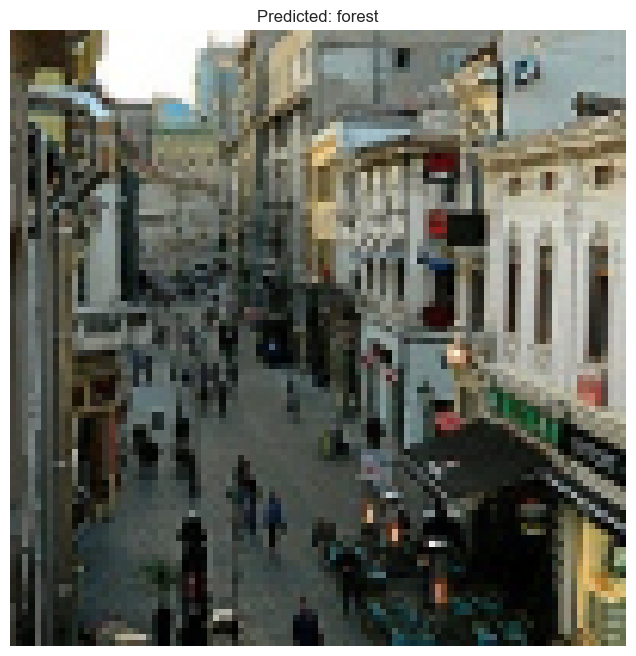

In [26]:
for i in np.random.randint(0, len(X_test), 8):
    predict_sample(X_test[i])